### Calibration using aaproximate bayes computation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from model_complex.compartmental_models import Calibration, EpidData, FactoryModel

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


##### Total regime

In [ ]:
epid_data = EpidData(city='samara', path='./', 
                start_time='01-07-2015', end_time='20-06-2016')
data_df = epid_data.get_wave_data(regime='total')
prepared_data = epid_data.prepare_for_calibration()
init_infected = [100]
model = FactoryModel.total()

/Users/andrey/model_complex/model_complex/compartmental_models/epid_data/epid_data.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.returned_df['total_cases'] = self.returned_df.fillna(0)[['real_cases_strain_1',


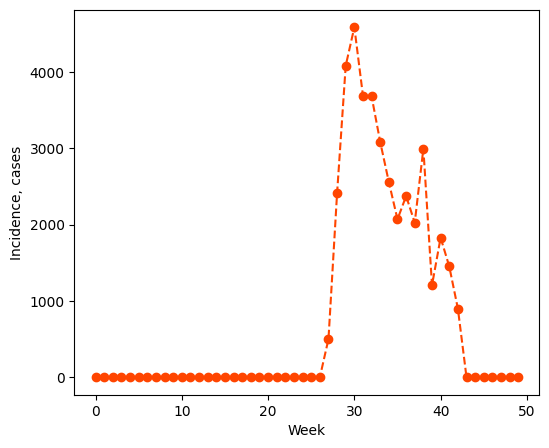

In [4]:
size = len(prepared_data)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_xlabel('Week')
ax.set_ylabel('Incidence, cases')
ax.plot(prepared_data[0:size], "--o", color='orangered')

In [5]:
rho = int(data_df['total_population'].iloc[0])
d = Calibration(init_infected, model, prepared_data, rho)
idata, data, simulation_func = d.abc_calibration()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Users/andrey/model_complex/.venv/lib/python3.11/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


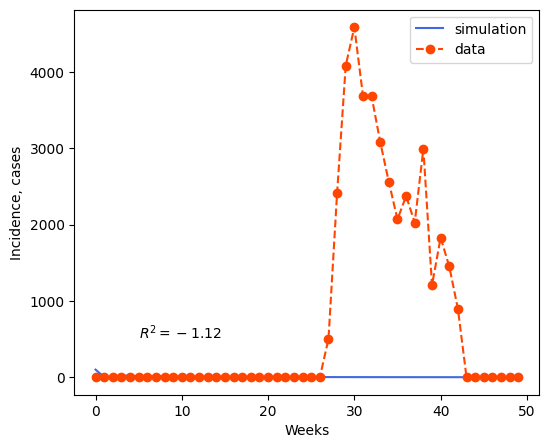

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
start_day = 15
posterior = idata.posterior.stack(samples=("draw", "chain"))
posterior
alpha = [posterior["alpha"].mean()]
beta = [posterior["beta"].mean()]
r2 = r2_score(list(data)[int(len(data)/2):], simulation_func(None, alpha, beta)[int(len(data)/2):])
r2 = round(r2, 2)
ax.text(5, 500, f'$R^2={r2}$')
ax.plot(simulation_func(None, alpha, beta), label='simulation', color='royalblue')
ax.plot(list(data), "--o", label='data', color='orangered')
ax.set_xlabel('Weeks')
ax.set_ylabel('Incidence, cases')
ax.legend()

##### Age regime

In [14]:
data_df = epid_data.get_wave_data(regime='age')
prepared_data = epid_data.prepare_for_calibration()
init_infected = [100, 100]
model =  FactoryModel.age()

/Users/andrey/model_complex/model_complex/compartmental_models/epid_data/epid_data.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.returned_df['total_cases'] = self.returned_df.fillna(0)[['real_cases_strain_1',
/Users/andrey/model_complex/model_complex/compartmental_models/epid_data/epid_data.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.returned_df['sars_cases_age_group_0-2'] = self.returned_df.fillna(0)[['sars_cases_age_group_0',
/Users/andrey/model_complex/model_complex/compartmen

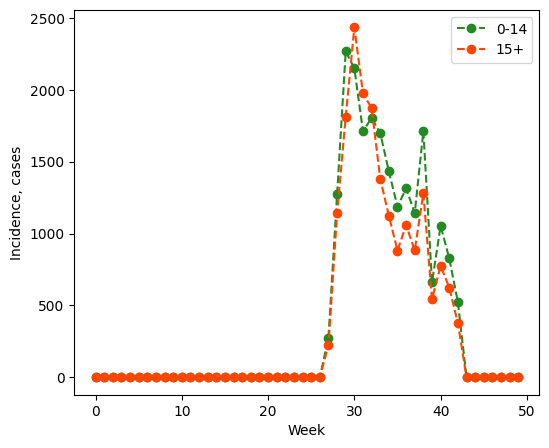

In [8]:
size = len(prepared_data)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_xlabel('Week')
ax.set_ylabel('Incidence, cases')
ax.plot(prepared_data[0:size//2], "--o", color='forestgreen', label='0-14')
ax.plot(prepared_data[size//2:size], "--o", color='orangered', label='15+')
ax.legend()

In [9]:
rho = int(data_df['total_population'].iloc[0])
d = Calibration(init_infected, model, prepared_data, rho)
idata, data, simulation_func = d.abc_calibration()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


[0.25450743 0.29267021]
[0.89215013 0.88666379 0.80685153 0.62864591]


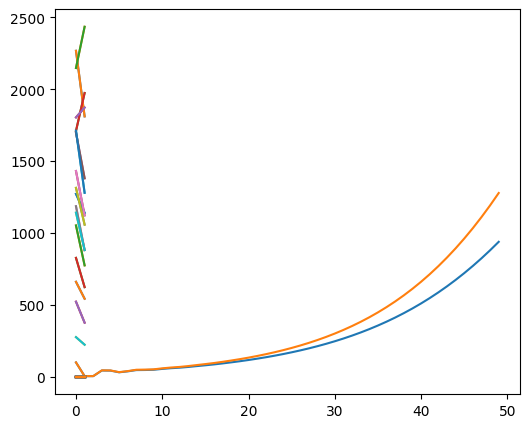

In [42]:
import numpy as np
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
start_day = 15    
posterior = idata.posterior.stack(samples=("draw", "chain"))
alpha_arr = np.array(posterior.alpha).mean(axis=1)
print(alpha_arr)

beta_arr = np.array(posterior.beta).mean(axis=1)
print(beta_arr)
model.simulate(alpha_arr, beta_arr, init_infected, rho, int(len(prepared_data)/model.alpha_len))
simulation_data = np.split(np.array(model.get_newly_infected()), model.alpha_len)
epid_data_incidence = np.split(prepared_data, model.alpha_len)
for sim, data in zip(simulation_data, epid_data_incidence):
    ax.plot(sim)
    ax.plot(epid_data_incidence)

In [40]:
epid_data_incidence[0]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,  275.82747106,
       1272.10543767, 2268.019439  , 2148.62554301, 1710.51209351,
       1804.69883114, 1698.76828853, 1431.8614687 , 1186.64940489,
       1314.34832859, 1142.02336029, 1712.67008455,  660.91338583,
       1052.71205906,  827.26841641,  522.55922865,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ])

In [39]:
simulation_data[0]

array([100.        ,   4.3240781 ,   4.51098977,  43.62153499,
        42.86028057,  31.14547457,  37.80259365,  46.58496855,
        47.16519643,  48.7169172 ,  54.83922899,  59.68367833,
        63.21379282,  68.26143529,  74.24104265,  79.98406866,
        86.07122687,  92.98837308, 100.41520905, 108.25366109,
       116.74867622, 125.96501734, 135.84970367, 146.46781489,
       157.91938154, 170.24588707, 183.49117951, 197.73265362,
       213.04539802, 229.49547991, 247.15868439, 266.11958453,
       286.46283115, 308.27549329, 331.65053582, 356.68467725,
       383.47684673, 412.12903823, 442.74617778, 475.43488388,
       510.30272909, 547.4576706 , 587.00693126, 629.05561895,
       673.70532873, 721.052506  , 771.18647582, 824.18723843,
       880.12303232, 939.04760331])